In [163]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(suppress=True)

In [13]:
dfs = {}
for file in os.listdir():
    split_name = file.split(".")
    if  split_name[-1] == "csv":
        dfs[int(split_name[0])] = pd.read_csv(file, index_col ='Index')
        dfs[int(split_name[0])].index = pd.to_datetime(dfs[int(split_name[0])].index)

In [41]:
open_to_open = {}
close_to_close = {} 
open_to_close = {}
high_to_low = {}
for name in dfs:
    open_to_open[name] = np.log(dfs[name]["Open"]).diff().shift(-1)
    close_to_close[name] = np.log(dfs[name]["Close"]).diff().shift(-1)
    open_to_close[name] = np.log(dfs[name]["Open"]) - np.log(dfs[name]["Close"])
    high_to_low[name] = np.log(dfs[name]["High"]) - np.log(dfs[name]["Low"])
open_to_open = pd.concat(open_to_open, axis=1)
close_to_close = pd.concat(close_to_close, axis=1)
open_to_close = pd.concat(open_to_close, axis=1)
high_to_low = pd.concat(high_to_low, axis=1)
return_list = [
    "open_to_open",
    "close_to_close",
    "open_to_close",
    "high_to_low"
]

## EDA

In [78]:
# 从结果看， 一号二号八号资产波动（风险）最大，六号七号十号波动（风险）最小。
# 一二六号资产在历史上取得正收益
for return_ in return_list:
    print(return_, "数据分析")
    print(locals()[return_].describe()[1:].T, "\n")

open_to_open 数据分析
        mean       std       min       25%       50%       75%       max
1   0.000220  0.026972 -0.241745 -0.013458  0.000919  0.013596  0.135427
2   0.000116  0.027669 -0.265703 -0.012202  0.000000  0.013615  0.150823
3  -0.000101  0.017751 -0.120953 -0.009527  0.000000  0.009431  0.099018
4  -0.000009  0.016194 -0.115143 -0.009069 -0.000844  0.008307  0.116433
5  -0.000176  0.018291 -0.096515 -0.008249  0.000000  0.008193  0.134442
6   0.000071  0.003032 -0.014997 -0.001546  0.000344  0.001781  0.016323
7  -0.000055  0.007012 -0.041964 -0.003590 -0.000392  0.003531  0.033572
8  -0.000307  0.020870 -0.145016 -0.010480  0.000000  0.010861  0.091937
9  -0.000281  0.013734 -0.085507 -0.008047  0.000752  0.008368  0.059285
10 -0.000021  0.007508 -0.056541 -0.002825  0.000590  0.003675  0.032374 

close_to_close 数据分析
        mean       std       min       25%       50%       75%       max
1   0.000198  0.029452 -0.400478 -0.012132  0.000765  0.012462  0.135724
2   0.00011

In [77]:
# 四号资产和七号资产偏度为正
# 二号资产kurt极大
other_info = pd.concat([
    open_to_open.skew(),
    open_to_open.kurt()
], axis=1)
other_info.columns = ["skew", "kurt"]
other_info

,skew,kurt
1,-0.663657,9.336681
2,-1.240166,14.096515
3,-0.334106,6.631912
4,0.453810,7.607522
5,-0.006750,6.988791
6,-0.381926,2.635229
7,0.060541,3.596602
8,-0.725271,4.910237
9,-0.517192,2.819962
10,-1.502631,8.942615


In [151]:
# 这一步用PCA做更好，没有的话就简单做
# 基于CAPM， 将收益序列分解成alpha 和 beta
market_return = open_to_open.mean(axis=1)
X = open_to_open
Y = market_return
beta = (X.T * Y).sum(axis=1) / (X ** 2).sum(axis=0)
residual = (Y - (beta * X).T).T
alphas = residual.mean(axis=0)
alpha_info = pd.concat([alphas, beta], axis=1)
alpha_info.columns = ["alphas","beta"]
alpha_info

,alphas,beta
1,-0.000094,0.182542
2,-0.000075,0.175980
3,-0.000038,0.165306
4,-0.000053,0.173503
5,-0.000032,0.126126
6,-0.000081,0.375172
7,-0.000048,0.119710
8,-0.000019,0.113929
9,0.000003,0.203272
10,-0.000054,0.008900


In [171]:
# 等同于上一步， 方便你理解而已
from sklearn.linear_model import LinearRegression
for i in range(10):
    i += 1
    ols = LinearRegression()
    ols.fit(X[[i]][:-1], Y[:-1])
    print(i, np.round(ols.intercept_, 4), np.round(ols.coef_[0], 4))

1 -0.0001 0.1826
2 -0.0001 0.176
3 -0.0 0.1653
4 -0.0001 0.1735
5 -0.0 0.1261
6 -0.0001 0.3758
7 -0.0 0.1197
8 -0.0 0.1139
9 0.0 0.2033
10 -0.0001 0.0089


In [ ]:
除了以上分析，要凑字数还可以describe 一下volume,， 把其他时段的收益都重复分析一遍，
还可以做一下ACF/ PACF 检验看看有没有存在自相关 (知乎搜索ARIMA, 就有教程)

In [175]:
# 或者这样子简单检验下
open_to_open.corrwith(open_to_open.shift(1))


1    -0.001542
2     0.063547
3    -0.057280
4    -0.021430
5     0.047583
6    -0.080907
7    -0.064971
8    -0.030822
9    -0.086703
10   -0.005044
dtype: float64

## 分析完了，开始写策略

In [245]:
# 策略就很简单，因为只有十个资产是量化不了的
# 举例，N 日内收益大于 M 日标准差就开仓
# 无多空限制，有的话策略要改

# 千万不要拿这个东西做实盘交易，实盘量化和这种东西是完全不同的。

In [259]:
def create_strategy(configs):
    signal = open_to_open.rolling(configs[0]).sum()
    threshold = open_to_open.rolling(configs[1]).std() * configs[2]
    condition = (signal.abs() > threshold)
    position = condition * np.sign(signal)
    strategy = (position.shift(1) * open_to_open).sum(axis=1)
    return strategy

In [262]:
max_sharpe = 0 
best_config = []
for config_0 in np.arange(1, 120):
    for config_1 in np.arange(10, 120, 10):
        for config_2 in np.arange(0.2, 2, 0.2):
            
            configs = [config_0, config_1, config_2]
            strategy = create_strategy(configs)
            
            sharpe = np.abs(strategy.mean() / strategy.std())
            if sharpe > max_sharpe:
                best_config = [config_0, config_1, config_2]
                max_sharpe = sharpe

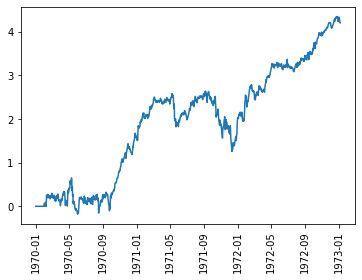

In [264]:

strategy = create_strategy(best_config)
plt.plot(-strategy.cumsum())
plt.xticks(rotation = 90)
plt.show()